# use just a ffnn to fit the two parameters of the model from a spectral slice
## for now the network is just in keras

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import pandas as pd
import os




import pickle
import socket
import matplotlib

from swissknife.bci import synthetic as syn
#plt.style.use('seaborn-pastel')
plt.style.use(matplotlib.style.available[19])

np.random.seed(0)
tf.set_random_seed(0)

comp_name=socket.gethostname()
print('Computer: ' + comp_name)

if 'manu' in comp_name:
    gpus = [1]
    os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

Computer: manu


In [2]:
# load the synthesis data
bci_folder = os.path.abspath('/mnt/cube/earneodo/bci_zf/finch_synth')
sweep_file = '/mnt/cube/earneodo/bci_zf/syn_sweeps/spectral_pandas_sweep_002.pickle'
df_syn = pd.read_pickle(sweep_file)

### filter frequency bands

In [3]:
def normalize(u):
    #normalize pe column
    u_max = np.repeat(np.amax(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_min = np.repeat(np.amin(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_range = u_max - u_min
    u_range[u_range == 0.] = 1
    return (u - u_min)/u_range

def filter_freq_band(df, f_min=0, f_max=10000):
    f_list = np.array(df.iloc[0].freq)
    f_sel = np.where((f_list >= f_min) & (f_list <= f_max))[0]
    f_filt = f_list[f_sel]
    
    all_spec_arr = np.array(df['spectral'].tolist())
    df['spectral'] = all_spec_arr[:, f_sel].tolist()
    return f_filt, df

def filter_par_range(df, par='a', value=-0.14987, precision=1e-2):
    int_value =int(value/precision)
    return df[((df[par]/precision).astype(np.int)) == int_value]

def transform_beta(beta):
    return (-beta/(3.))

def transform_beta_inv(beta):
    return (-beta*(3.))

In [4]:
all_spectra_array = np.array(df_syn['spectral'].tolist())
#plt.plot(all_spectra[1]);
all_spectra_array.shape

(160000, 86)

In [5]:
a_value = -0.14987
f_list, filt_df = filter_freq_band(df_syn, f_min=0, f_max=10000)
df_a_line = filter_par_range(df_syn, value=a_value)
np.unique(df_a_line.a)

array([-0.14987342, -0.14886076, -0.1478481 , -0.14683544, -0.14582278,
       -0.14481013, -0.14379747, -0.14278481, -0.14177215, -0.14075949])

In [6]:
f_list.shape

(86,)

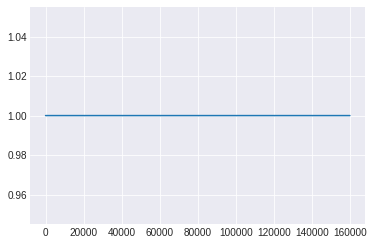

In [7]:
plt.plot((all_spectra_array).max(axis=1))

In [8]:
# a batch generator using pandas
class PdBatcher(object):
    def __init__(self, data_frame, x_field=None, y_field=None, train_fraction=0.9):
        self.data_frame = data_frame.sample(frac=1)
        self.train_fraction = train_fraction
        self.x_field = x_field
        self.y_field = y_field
        
        self.max_pow = np.amax(data_frame['spectral'].max())
        self._split()
        self._make_train_array()
        self._make_test_array()
        
    def _split(self):
        random_frac = int(self.data_frame.shape[0] * self.train_fraction)
        self.test_frame = self.data_frame[random_frac:]
        self.train_frame = self.data_frame[:random_frac]
        
    def _make_train_array(self):
        all_spectra = np.array(self.train_frame['spectral'].as_matrix())
        self.all_train_array = np.concatenate([np.array(s) for s in all_spectra], axis=1)/self.max_pow
        self.all_label_array = np.arange(self.all_train_array.shape[1])%len(all_spectra[0][1])
        
    def _make_test_array(self):
        all_spectra = np.array(self.test_frame['spectral'].as_matrix())
        self.all_test_array = np.stack([np.array(s)[:,:300] for s in all_spectra], axis=0)/self.max_pow
        
    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[1], n)
        return [self.all_train_array[:, idx].T, self.all_label_array[idx]]
    
    def test_batch(self, n_mot):
        idx = np.random.randint(0, self.all_test_array.shape[0], n_mot)
        test_array_batch = self.all_test_array[idx]
        return test_array_batch
    
# a batch generator using pandas
class SynBatcher(PdBatcher):
    def __init__(self, data_frame, x_field=None, y_field=None, train_fraction=0.9):
    
        PdBatcher.__init__(self, data_frame, 
              x_field=x_field, y_field=y_field, train_fraction=train_fraction)
       
    def _make_train_array(self):
        all_spectra = (np.array(self.train_frame['spectral'].as_matrix()))
        self.all_train_array = np.stack([np.array(s) for s in all_spectra])/self.max_pow
        self.train_label_array = np.array([self.train_frame['a'], self.train_frame['b']]).T
        
    def _make_test_array(self):
        all_spectra = (np.array(self.test_frame['spectral'].as_matrix()))
        self.all_test_array = np.stack([np.array(s) for s in all_spectra])/self.max_pow
        self.test_label_array = np.array([self.test_frame['a'], self.test_frame['b']]).T

    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[0], n).tolist()
        return [(self.all_train_array[idx]), self.train_label_array[idx]]
    
    def test_batch(self, n):
        idx = np.random.randint(0, self.all_test_array.shape[0], n).tolist()
        return [(self.all_test_array[idx]), self.test_label_array[idx]]

#pdb = PdBatcher(df.loc[df['bird'].isin(['z007', 'z020', 'z017'])])
pdb = SynBatcher(df_a_line, train_fraction = 0.9)
print(df_a_line.shape)
b_size = 100
x, y = pdb.train_batch(b_size)
n_samples = pdb.all_train_array.shape[0]

(20000, 6)


In [9]:
x, y = pdb.test_batch(b_size)

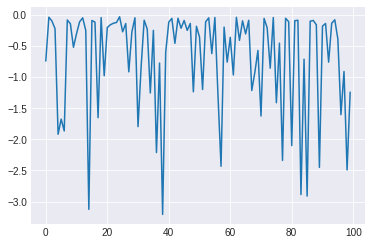

In [10]:
plt.plot((y[:,1]))

In [11]:
pdb.all_train_array.shape

(18000, 86)

In [12]:
df_a_line.shape

(20000, 6)

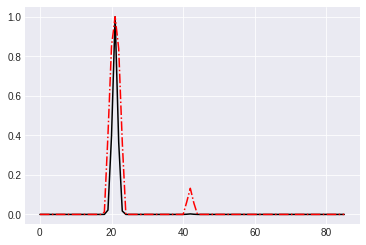

In [13]:
x, y = pdb.test_batch(b_size)
sl = 90
plt.plot((x[sl]), 'k')
plt.plot(syn.np_mulog(x[sl]), 'r-.')

## Make the network with keras

In [14]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Input
from keras.layers import LSTM, Activation, advanced_activations
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model

Using TensorFlow backend.


In [15]:
## Make the network with keras

big_batch_size = pdb.all_train_array.shape[0]
n_feat = pdb.all_train_array.shape[-1]

fit_pars = {'num_ep': 100,
           'batch_size': 5,
           'valid_split': 0.1}

l2_val = 0.001
dropout_val = 0.2

# the proper network
slice_input = Input(shape=(n_feat, ), name='input')
#x = Dense(n_feat*2, kernel_initializer='uniform', activation='relu')(slice_input)
x = Dense(n_feat, kernel_initializer='uniform', activation='elu')(slice_input)
x = Dense(n_feat//2, kernel_initializer='uniform', activation='elu')(x)
x = Dropout(dropout_val)(x)
x = Dense(n_feat//4, kernel_initializer='uniform', activation='elu')(x)
x = Dropout(dropout_val)(x)
x = Dense(n_feat//16, kernel_initializer='uniform', activation='elu')(x)
x = Dropout(dropout_val)(x)

#x = Dense(n_feat//64, kernel_initializer='uniform', activation='relu')(x)

par_output = Dense(1, kernel_initializer='normal', name='par_output')(x)

model = Model(inputs=slice_input, 
             outputs=par_output)

model.compile(optimizer='adam',
              loss={'par_output': 'mean_squared_error'})


model_name = 'inverter_one_a.h5'
model_path = os.path.join(bci_folder, 'networks', 'model_' + model_name)
callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1),
             ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=2)
            ]


X, Y = pdb.train_batch(big_batch_size)

model.fit({'input': X},
         {'par_output': transform_beta(Y[:,1])},
         epochs=fit_pars['num_ep'],
         batch_size=fit_pars['batch_size'],
         validation_split=fit_pars['valid_split'],
         callbacks=callbacks,
         verbose=2)


Train on 16200 samples, validate on 1800 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.00080, saving model to /mnt/cube/earneodo/bci_zf/finch_synth/networks/model_inverter_one_a.h5
10s - loss: 0.0081 - val_loss: 8.0121e-04
Epoch 2/100
Epoch 00001: val_loss did not improve
10s - loss: 0.0049 - val_loss: 8.2407e-04
Epoch 3/100
Epoch 00002: val_loss improved from 0.00080 to 0.00027, saving model to /mnt/cube/earneodo/bci_zf/finch_synth/networks/model_inverter_one_a.h5
10s - loss: 0.0049 - val_loss: 2.7000e-04
Epoch 4/100
Epoch 00003: val_loss did not improve
10s - loss: 0.0048 - val_loss: 3.9274e-04
Epoch 5/100
Epoch 00004: val_loss did not improve
10s - loss: 0.0048 - val_loss: 4.2648e-04
Epoch 6/100
Epoch 00005: val_loss did not improve
10s - loss: 0.0048 - val_loss: 5.2053e-04
Epoch 7/100
Epoch 00006: val_loss improved from 0.00027 to 0.00013, saving model to /mnt/cube/earneodo/bci_zf/finch_synth/networks/model_inverter_one_a.h5
10s - loss: 0.0049 - val_loss: 1.3298e

### Test the inversion with synth data

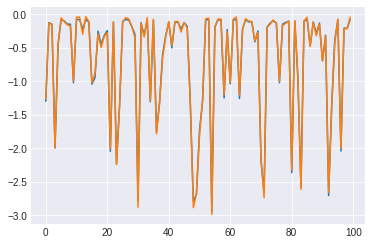

In [16]:
test_batch_size = pdb.all_test_array.shape[0]

X_t, Y_t = pdb.train_batch(test_batch_size)

model_pred = model.predict(X_t, batch_size=fit_pars['batch_size'])

plt.plot(transform_beta_inv(model_pred)[:100])
plt.plot((Y_t[:100, 1]))


In [17]:
# a batch generator using pandas
birds_sessions = {'z020': ['day-2016-06-02', 'day-2016-06-03', 'day-2016-06-04', 'day-2016-06-05', 'day-2016-06-06'],
                 'z017': ['day-2016-06-17', 'day-2016-06-18', 'day-2016-06-19', 'day-2016-06-20', 'day-2016-06-21', 
                          'day-2016-06-22', 'day-2016-06-23', 'day-2016-06-24', 'day-2016-06-27', 'day-2016-06-28'],
                  'z007': ['day-2016-09-07', 'day-2016-09-09', 'day-2016-09-10', 'day-2016-09-11', 'day-2016-09-12', 
                           'day-2016-09-13', 'day-2016-09-14']
                 }

all_df = []

for bird, sess_list in birds_sessions.items():
    if bird=='z007':
        for sess in sess_list:
            data_file = os.path.join('/mnt/cube/earneodo/bci_zf/ss_data/', bird, sess, 'spectral_pandas.pickle')
            all_df.append(pd.read_pickle(data_file))

        
bird_df = pd.concat(all_df)
bird_f_list, _ = filter_freq_band(bird_df)
print(bird_f_list)
print(bird_f_list.shape)

[    0.       117.1875   234.375    351.5625   468.75     585.9375
   703.125    820.3125   937.5     1054.6875  1171.875   1289.0625  1406.25
  1523.4375  1640.625   1757.8125  1875.      1992.1875  2109.375
  2226.5625  2343.75    2460.9375  2578.125   2695.3125  2812.5     2929.6875
  3046.875   3164.0625  3281.25    3398.4375  3515.625   3632.8125  3750.
  3867.1875  3984.375   4101.5625  4218.75    4335.9375  4453.125
  4570.3125  4687.5     4804.6875  4921.875   5039.0625  5156.25    5273.4375
  5390.625   5507.8125  5625.      5742.1875  5859.375   5976.5625  6093.75
  6210.9375  6328.125   6445.3125  6562.5     6679.6875  6796.875
  6914.0625  7031.25    7148.4375  7265.625   7382.8125  7500.      7617.1875
  7734.375   7851.5625  7968.75    8085.9375  8203.125   8320.3125  8437.5
  8554.6875  8671.875   8789.0625  8906.25    9023.4375  9140.625
  9257.8125  9375.      9492.1875  9609.375   9726.5625  9843.75    9960.9375]
(86,)


In [18]:
bird_df.shape

(306, 6)

In [19]:
bird_df.head()

,bird,freq,rec,sess,spectral,start
0,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",6,day-2016-09-07,"[[2943.5121153462746, 2943.5121153462746, 2943...",7895887
1,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",6,day-2016-09-07,"[[3211.418797809429, 3211.418797809429, 3211.4...",7946538
2,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",6,day-2016-09-07,"[[3127.9031453957914, 3127.9031453957914, 3127...",7946531
3,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",7,day-2016-09-07,"[[5458.382323937923, 5458.382323937923, 5458.3...",825505
4,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",7,day-2016-09-07,"[[2889.9109922802486, 2889.9109922802486, 2889...",849868


In [20]:
bird_spectra_array = np.array(bird_df['spectral'].as_matrix())
#plt.plot(all_spectra[1]);
bird_spectra_array.shape

(306,)

In [21]:
pdb.all_test_array.shape

(2000, 86)

In [22]:
class PdBatcher(object):
    def __init__(self, data_frame, x_field=None, y_field=None, train_fraction=0.9):
        self.data_frame = data_frame.sample(frac=1)
        self.train_fraction = train_fraction
        self.x_field = x_field
        self.y_field = y_field
        
        self.max_pow = np.amax(data_frame['spectral'].max())
        self._split()
        self._make_train_array()
        self._make_test_array()
        
    def _split(self):
        random_frac = int(self.data_frame.shape[0] * self.train_fraction)
        self.data_frame.fillna(0)
        self.train_frame = self.data_frame[random_frac:]
        self.test_frame = self.data_frame[:random_frac]
        
    def _make_train_array(self):
        all_spectra = np.array(self.train_frame['spectral'].as_matrix())
        self.all_train_array = np.concatenate([np.array(s) for s in all_spectra], axis=1)
        self.all_label_array = np.arange(self.all_train_array.shape[1])%len(all_spectra[0][1])
        
        no_silence = np.where(np.nansum(self.all_train_array, axis=0)>0)[0]
        self.all_train_array = (self.all_train_array[:, no_silence])
        self.all_label_array = self.all_label_array[no_silence]


        
    def _make_test_array(self):
        all_spectra = np.array(self.test_frame['spectral'].as_matrix())
        self.all_test_array = (np.stack([np.array(s)[:,:593] for s in all_spectra], axis=0))
        
    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[1], n)
        return [((self.all_train_array[:, idx].T)), self.all_label_array[idx]]
    
    def test_batch(self, n_mot):
        idx = np.random.randint(0, self.all_test_array.shape[0], n_mot)
        test_array_batch = (self.all_test_array[idx])
        return test_array_batch


pd_bird = PdBatcher(bird_df[bird_df.sess=='day-2016-09-10'])
print(bird_df.shape)
x, y = pd_bird.train_batch(100)
n_samples = pd_bird.all_train_array.shape[-1]

(306, 6)


In [23]:
pd_bird.all_train_array.shape

(86, 4712)

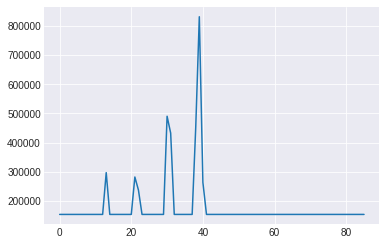

In [24]:
b_size = 100
#x, y = pd_bird.train_batch(b_size)
plt.plot(x[3])

/home/earneodo/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


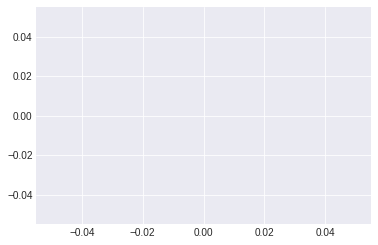

In [25]:
xs = normalize(pd_bird.test_batch(1)[0])
plt.plot(xs[1]/np.mean(xs[1]))


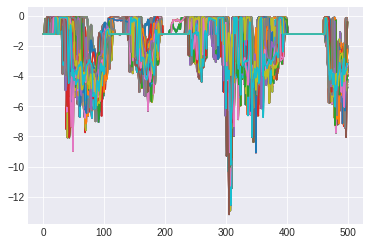

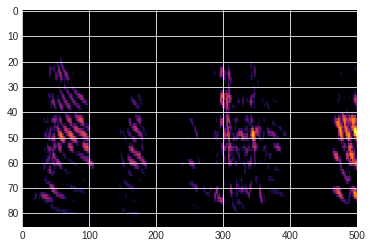

In [26]:
def beta_fit(x_slices, model, fit_pars):
    model_pred = model.predict(x_slices, batch_size=fit_pars['batch_size'])
    return transform_beta_inv(model_pred.flatten())

def motiff_pars(n_motiff, model, fit_pars):
    x_test = pd_bird.test_batch(n_motiff)
    x_reconstruct = []
    for i in range(n_motiff):
        x_i= []
        for j in range(x_test.shape[-1]//b_size):
            x_slices = normalize(((x_test[i, :, j*b_size:(j+1)*b_size]).T))
            #print(x_slices.shape)
            for m in range(x_slices.shape[0]):
                x_slices[m] = x_slices[m]*np.sum(x_slices[m])
                
            par_for_slices = beta_fit(x_slices, model, fit_pars).flatten()
            x_i.append(par_for_slices)
        x_reconstruct.append(np.concatenate(x_i))
    return np.stack(x_reconstruct, axis=0), x_test



x_r, x_test = motiff_pars(500, model, fit_pars)
x_r.shape
plt.figure()
sample_view = 0
plt.plot(x_r.T)
#plt.imshow(x_r[sample_view].T[::-1], aspect='auto', cmap='inferno')
plt.figure()
plt.imshow(np.log(x_test[sample_view][:,:x_r.shape[-1]][::-1]), aspect='auto', cmap='inferno')

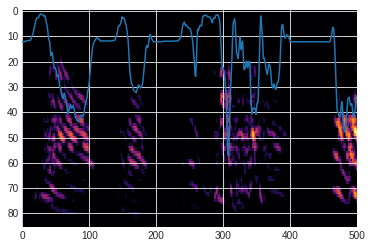

In [27]:
plt.plot(-10*x_r.mean(axis=0))
plt.imshow(np.log(x_test[sample_view][:,:x_r.shape[-1]][::-1]), aspect='auto', cmap='inferno')